In [1]:
from tensorflow import keras

In [14]:
!pip3 install matplotlib

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 11.6 MB 100 kB/s eta 0:00:01    |████████████████████            | 7.2 MB 532 kB/s eta 0:00:09     |█████████████████████████▉      | 9.3 MB 236 kB/s eta 0:00:10     |███████████████████████████▌    | 9.9 MB 1.3 MB/s eta 0:00:02
     |████████████████████████████████| 2.2 MB 273 kB/s eta 0:00:01     |███████▏                        | 491 kB 85 kB/s eta 0:00:20     |██████████▎                     | 706 kB 157 kB/s eta 0:00:10     |███████████████████████▋        | 1.6 MB 112 kB/s eta 0:00:06
     |████████████████████████████████| 88 kB 125 kB/s eta 0:00:01


In [2]:
import tensorflow as tf
#

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only allocate 1GB of memory on the first GPU
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
tf.compat.v1.disable_eager_execution()

In [6]:
from tensorflow.keras.applications import inception_v3
from tensorflow.keras import backend as K

# We will not be training our model,
# so we use this command to disable all training-specific operations
K.set_learning_phase(0)

# Build the InceptionV3 network.
# The model will be loaded with pre-trained ImageNet weights.
model = inception_v3.InceptionV3(weights='imagenet',
                                 include_top=False)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [7]:
# quantifying how much the layer's activation
# will contribute to the loss we will seek to maximize.
# Note that these are layer names as they appear
# in the built-in InceptionV3 application.
# You can list all layer names using `model.summary()`.
layer_contributions = {
    'mixed2': 0.6,
    'mixed3': 3.,
    'mixed4': 2.,
    'mixed5': 1.5,
}

In [8]:
layer_dict = dict([(layer.name, layer) for layer in model.layers])

# Define the loss.
loss = K.variable(0.)
for layer_name in layer_contributions:
    # Add the L2 norm of the features of a layer to the loss.
    coeff = layer_contributions[layer_name]
    activation = layer_dict[layer_name].output

    # We avoid border artifacts by only involving non-border pixels in the loss.
    scaling = K.prod(K.cast(K.shape(activation), 'float32'))
    loss = loss + coeff * K.sum(K.square(activation[:, 2: -2, 2: -2, :])) / scaling

In [9]:
# This holds our generated image
dream = model.input

# Compute the gradients of the dream with regard to the loss.
grads = K.gradients(loss, dream)[0]

# Normalize gradients.
grads /= K.maximum(K.mean(K.abs(grads)), 1e-7)

# Set up function to retrieve the value
# of the loss and gradients given an input image.
outputs = [loss, grads]
fetch_loss_and_grads = K.function([dream], outputs)

def eval_loss_and_grads(x):
    outs = fetch_loss_and_grads([x])
    loss_value = outs[0]
    grad_values = outs[1]
    return loss_value, grad_values

def gradient_ascent(x, iterations, step, max_loss=None):
    for i in range(iterations):
        loss_value, grad_values = eval_loss_and_grads(x)
        if max_loss is not None and loss_value > max_loss:
            break
        print('...Loss value at', i, ':', loss_value)
        x += step * grad_values
    return x

In [10]:
import scipy.misc
import imageio

from tensorflow.keras.preprocessing import image

def resize_img(img, size):
    img = np.copy(img)
    factors = (1,
               float(size[0]) / img.shape[1],
               float(size[1]) / img.shape[2],
               1)
    return scipy.ndimage.zoom(img, factors, order=1)


def save_img(img, fname):
    pil_img = deprocess_image(np.copy(img))
    imageio.imwrite(fname, pil_img)


def preprocess_image(image_path):
    # Util function to open, resize and format pictures
    # into appropriate tensors.
    img = image.load_img(image_path)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = inception_v3.preprocess_input(img)
    return img


def deprocess_image(x):
    # Util function to convert a tensor into a valid image.
    if K.image_data_format() == 'channels_first':
        x = x.reshape((3, x.shape[2], x.shape[3]))
        x = x.transpose((1, 2, 0))
    else:
        x = x.reshape((x.shape[1], x.shape[2], 3))
    x /= 2.
    x += 0.5
    x *= 255.
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [11]:
import numpy as np

# Playing with these hyperparameters will also allow you to achieve new effects

step = 0.01  # Gradient ascent step size
num_octave = 5  # Number of scales at which to run gradient ascent
octave_scale = 1.5  # Size ratio between scales
iterations = 20  # Number of ascent steps per scale

# If our loss gets larger than 10,
# we will interrupt the gradient ascent process, to avoid ugly artifacts
max_loss = 10.

# Fill this to the path to the image you want to use
base_image_path = '/home/ahmed/Downloads/ahmed.jpg'

# Load the image into a Numpy array
img = preprocess_image(base_image_path)

# We prepare a list of shape tuples
# defining the different scales at which we will run gradient ascent
original_shape = img.shape[1:3]
successive_shapes = [original_shape]
for i in range(1, num_octave):
    shape = tuple([int(dim / (octave_scale ** i)) for dim in original_shape])
    successive_shapes.append(shape)

# Reverse list of shapes, so that they are in increasing order
successive_shapes = successive_shapes[::-1]

# Resize the Numpy array of the image to our smallest scale
original_img = np.copy(img)
shrunk_original_img = resize_img(img, successive_shapes[0])

for shape in successive_shapes:
    print('Processing image shape', shape)
    img = resize_img(img, shape)
    img = gradient_ascent(img,
                          iterations=iterations,
                          step=step,
                          max_loss=max_loss)
    upscaled_shrunk_original_img = resize_img(shrunk_original_img, shape)
    same_size_original = resize_img(original_img, shape)
    lost_detail = same_size_original - upscaled_shrunk_original_img

    img += lost_detail
    shrunk_original_img = resize_img(original_img, shape)
    save_img(img, fname='dream_at_scale_' + str(shape) + '.png')

save_img(img, fname='final_dream.png')

Processing image shape (160, 284)
...Loss value at 0 : 1.6368552
...Loss value at 1 : 1.9499168
...Loss value at 2 : 2.5402794
...Loss value at 3 : 3.2453065
...Loss value at 4 : 3.8589163
...Loss value at 5 : 4.4343886
...Loss value at 6 : 4.9421353
...Loss value at 7 : 5.458557
...Loss value at 8 : 5.8969946
...Loss value at 9 : 6.397788
...Loss value at 10 : 6.8225718
...Loss value at 11 : 7.2480083
...Loss value at 12 : 7.6223736
...Loss value at 13 : 7.97478
...Loss value at 14 : 8.372024
...Loss value at 15 : 8.786476
...Loss value at 16 : 9.1973915
...Loss value at 17 : 9.604046
...Loss value at 18 : 9.925268
Processing image shape (240, 426)
...Loss value at 0 : 2.574108
...Loss value at 1 : 3.784324
...Loss value at 2 : 4.8088202
...Loss value at 3 : 5.691074
...Loss value at 4 : 6.5812535
...Loss value at 5 : 7.347152
...Loss value at 6 : 8.099532
...Loss value at 7 : 8.827324
...Loss value at 8 : 9.4938135
Processing image shape (360, 640)
...Loss value at 0 : 2.5283725
...L

ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[1,768,44,84] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradients/Square_3_grad/Mul_1-1-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[truediv_4/_2271]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[1,768,44,84] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradients/Square_3_grad/Mul_1-1-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

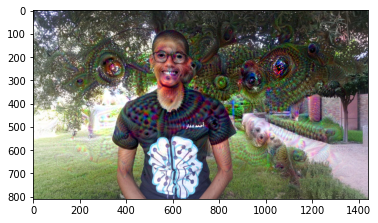

In [15]:
from matplotlib import pyplot as plt

plt.imshow(deprocess_image(np.copy(img)))
plt.show()
